In [1]:
import os
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from sklearn.metrics import confusion_matrix

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from Methods import load_images, plot_sample_images, plot_model_metrics, plot_images_with_predictions, plot_confusion_matrix, plot_mismatched_images

In [3]:
image_dir = os.path.dirname(os.getcwd())+"\\Screenshots\\InContextInitial\\"
data = load_images(image_dir)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     1440 non-null   int64 
 1   filename  1440 non-null   object
 2   label     1440 non-null   object
 3   img       1440 non-null   object
dtypes: int64(1), object(3)
memory usage: 45.1+ KB


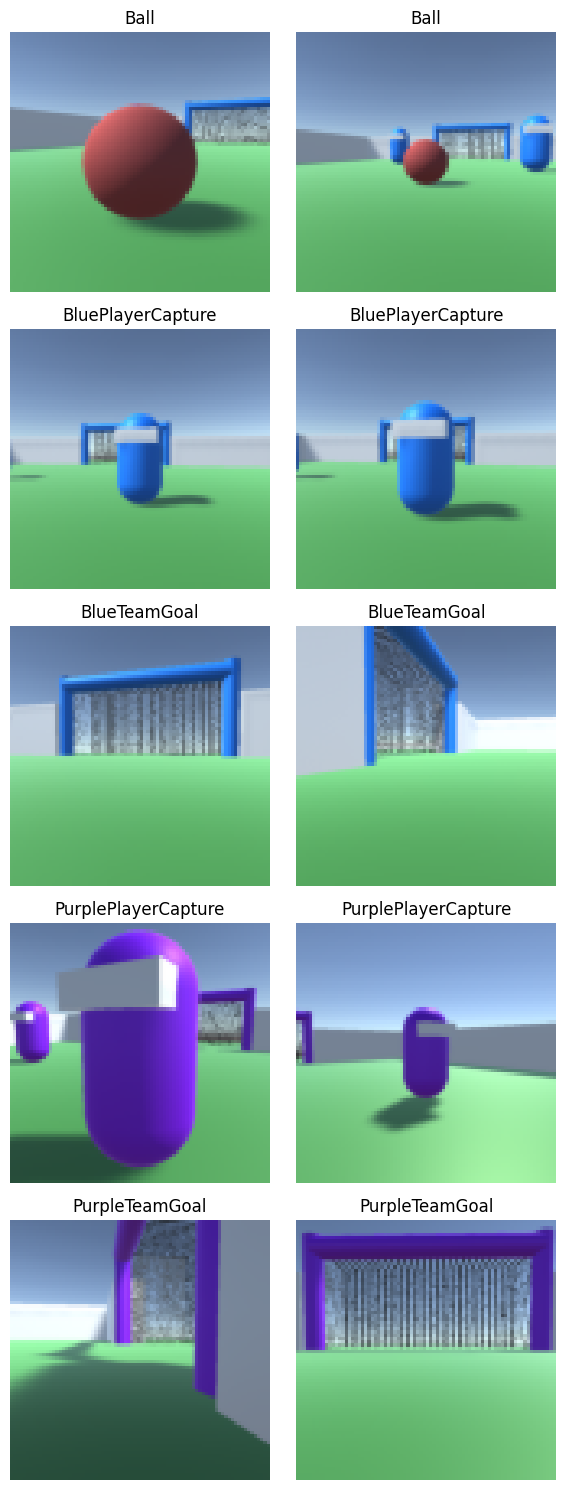

In [4]:
plot_sample_images(data)

In [5]:
#Splitting the data into training and testing
train_df, test_df = train_test_split(data, test_size=0.3)

# Datagen for training data. Augment the data by rotating, shifting, flipping, to make the model more robust and less prone to overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
    directory=image_dir,
    target_size=(64, 64),
    x_col='filename',
    y_col='label',
    batch_size=64,
    class_mode='categorical'
)



Found 1008 validated image filenames belonging to 5 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=64,
    class_mode= "categorical",
    shuffle=False
)

Found 432 validated image filenames belonging to 5 classes.


In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_initial = model.fit(train_generator,validation_data = test_generator, epochs=30)

C:\Users\Søren Merved\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


C:\Users\Søren Merved\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.2549 - loss: 1.9269 - val_accuracy: 0.7639 - val_loss: 0.8110
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6961 - loss: 0.7650 - val_accuracy: 0.9120 - val_loss: 0.2868
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8880 - loss: 0.3368 - val_accuracy: 0.8981 - val_loss: 0.4433
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9049 - loss: 0.2525 - val_accuracy: 0.9144 - val_loss: 0.3226
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9380 - loss: 0.1518 - val_accuracy: 0.9259 - val_loss: 0.2912
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9633 - loss: 0.1417 - val_accuracy: 0.9282 - val_loss: 0.2005
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9708 - loss: 0.1032 - val_accuracy: 0.9444 - val_loss: 0.1679
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9591 - loss: 0.1231 - val_accuracy: 0.9190 - val_

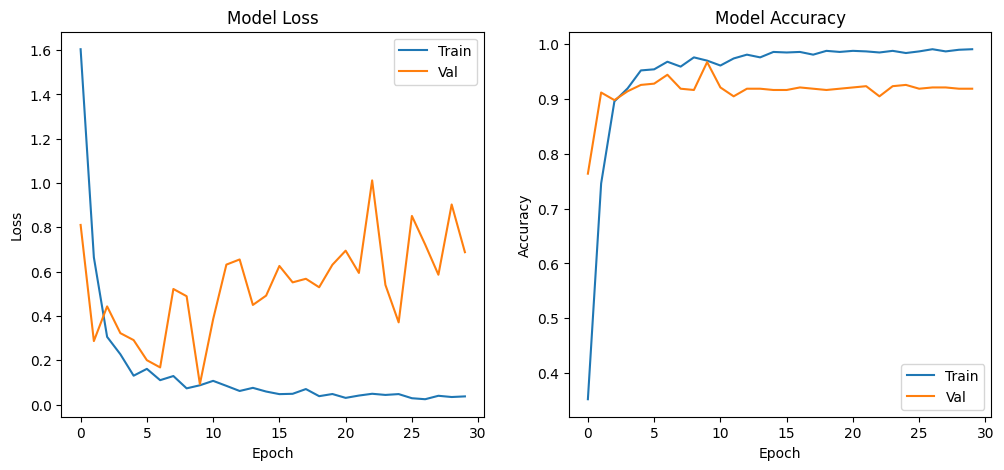

In [8]:
plot_model_metrics(trained_model_initial)

In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_reduced_lr = model.fit(train_generator,validation_data = test_generator, epochs=30)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.2157 - loss: 1.5983 - val_accuracy: 0.2269 - val_loss: 1.4485
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.4262 - loss: 1.4425 - val_accuracy: 0.6528 - val_loss: 1.1170
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.6221 - loss: 1.1924 - val_accuracy: 0.7940 - val_loss: 0.8222
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.6797 - loss: 0.9861 - val_accuracy: 0.7639 - val_loss: 0.6609
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7382 - loss: 0.8013 - val_accuracy: 0.8356 - val_loss: 0.5468
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.7394 - loss: 0.7426 - val_accuracy: 0.8380 - val_loss: 0.4805
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.8217 - loss: 0.6363 - val_accuracy: 0.8912 - val_loss: 0.3881
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8252 - loss: 0.5513 - val_accuracy: 0.

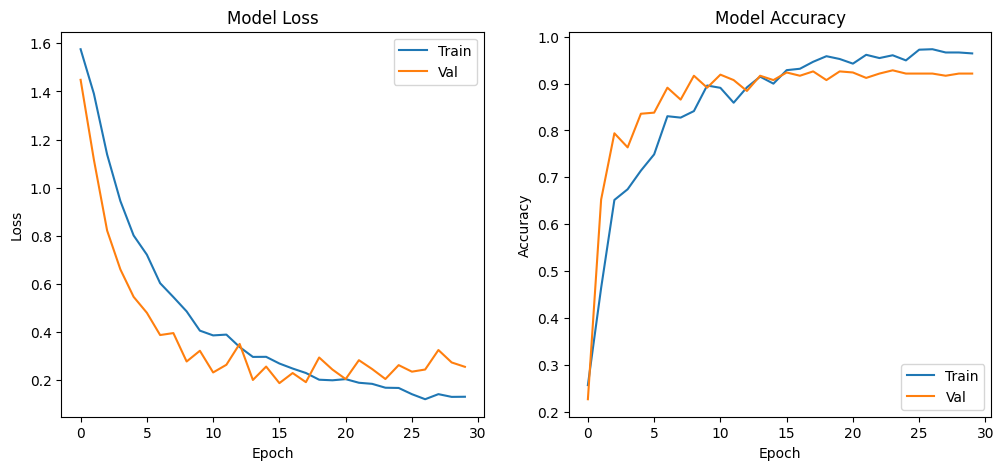

In [10]:
plot_model_metrics(trained_model_reduced_lr)

In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_inc_epochs = model.fit(train_generator,validation_data = test_generator, epochs=60)

Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.2538 - loss: 1.5995 - val_accuracy: 0.6273 - val_loss: 1.2745
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4803 - loss: 1.3400 - val_accuracy: 0.7060 - val_loss: 0.9664
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.6112 - loss: 1.1013 - val_accuracy: 0.7755 - val_loss: 0.7622
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6520 - loss: 0.9496 - val_accuracy: 0.7569 - val_loss: 0.7083
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7172 - loss: 0.7835 - val_accuracy: 0.7917 - val_loss: 0.5536
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8281 - loss: 0.6923 - val_accuracy: 0.8426 - val_loss: 0.4594
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8162 - loss: 0.6146 - val_accuracy: 0.8727 - val_loss: 0.4562
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.8467 - loss: 0.5296 - val_accuracy: 0.

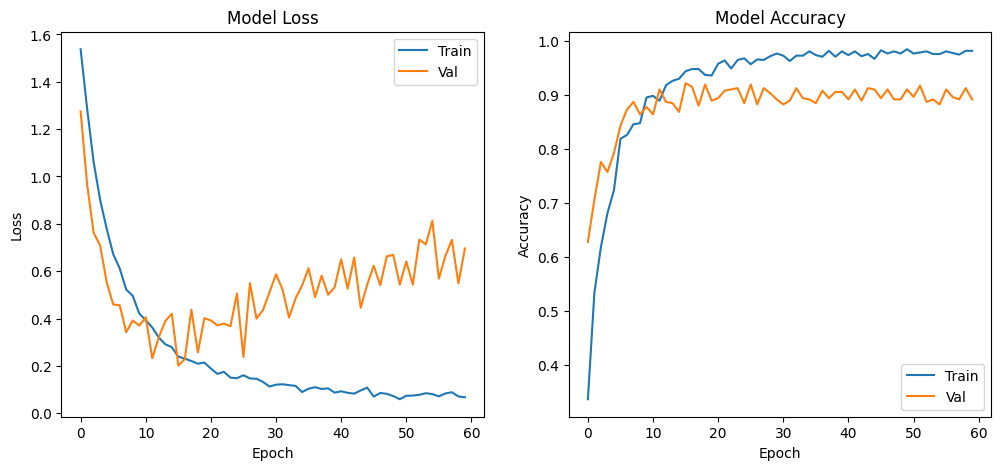

In [12]:
plot_model_metrics(trained_model_inc_epochs)

In [13]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_simplified = model.fit(train_generator,validation_data = test_generator, epochs=60)

C:\Users\Søren Merved\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.2368 - loss: 1.5898 - val_accuracy: 0.3542 - val_loss: 1.4904
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.4571 - loss: 1.5058 - val_accuracy: 0.6389 - val_loss: 1.3463
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.5004 - loss: 1.4121 - val_accuracy: 0.6782 - val_loss: 1.1946
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.5752 - loss: 1.2827 - val_accuracy: 0.7917 - val_loss: 1.0356
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.6025 - loss: 1.1746 - val_accuracy: 0.7755 - val_loss: 0.9046
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.6818 - loss: 1.0438 - val_accuracy: 0.7477 - val_loss: 0.8004
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.6547 - loss: 0.9938 - val_accuracy: 0.7986 - val_loss: 0.6993
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7217 - loss: 0.8859 - val_accuracy: 0.8264 -

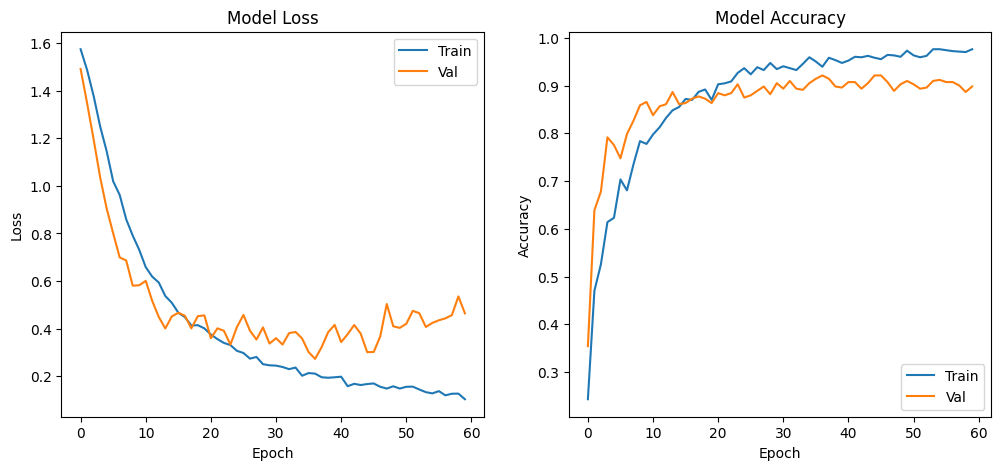

In [14]:
plot_model_metrics(trained_model_simplified)

In [15]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_incresed_lr = model.fit(train_generator,validation_data = test_generator, epochs=60)

C:\Users\Søren Merved\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.2862 - loss: 1.5843 - val_accuracy: 0.4236 - val_loss: 1.3913
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.4096 - loss: 1.4341 - val_accuracy: 0.6574 - val_loss: 1.1600
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5468 - loss: 1.2537 - val_accuracy: 0.8403 - val_loss: 0.9167
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6688 - loss: 1.0750 - val_accuracy: 0.7546 - val_loss: 0.7599
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6952 - loss: 0.9115 - val_accuracy: 0.8333 - val_loss: 0.6325
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.7821 - loss: 0.7534 - val_accuracy: 0.8380 - val_loss: 0.5346
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7854 - loss: 0.6670 - val_accuracy: 0.8356 - val_loss: 0.4417
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8017 - loss: 0.5908 - val_accuracy: 0.

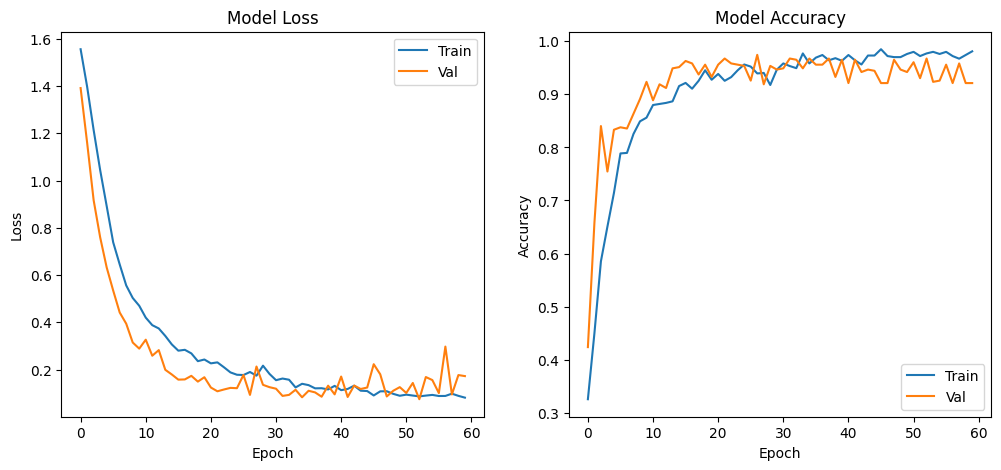

In [16]:
plot_model_metrics(trained_model_incresed_lr)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
[[94  0  0  0  0]
 [ 0 95  0  0  0]
 [ 0  0 36  0 34]
 [ 0  0  0 92  0]
 [ 0  0  0  0 81]]


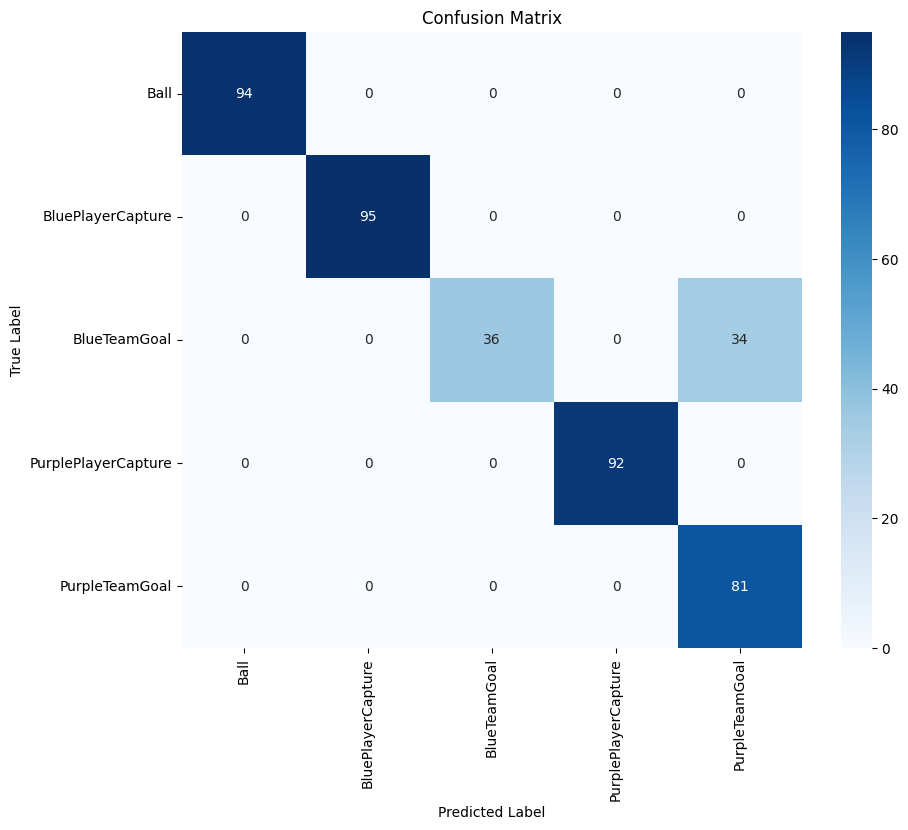

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


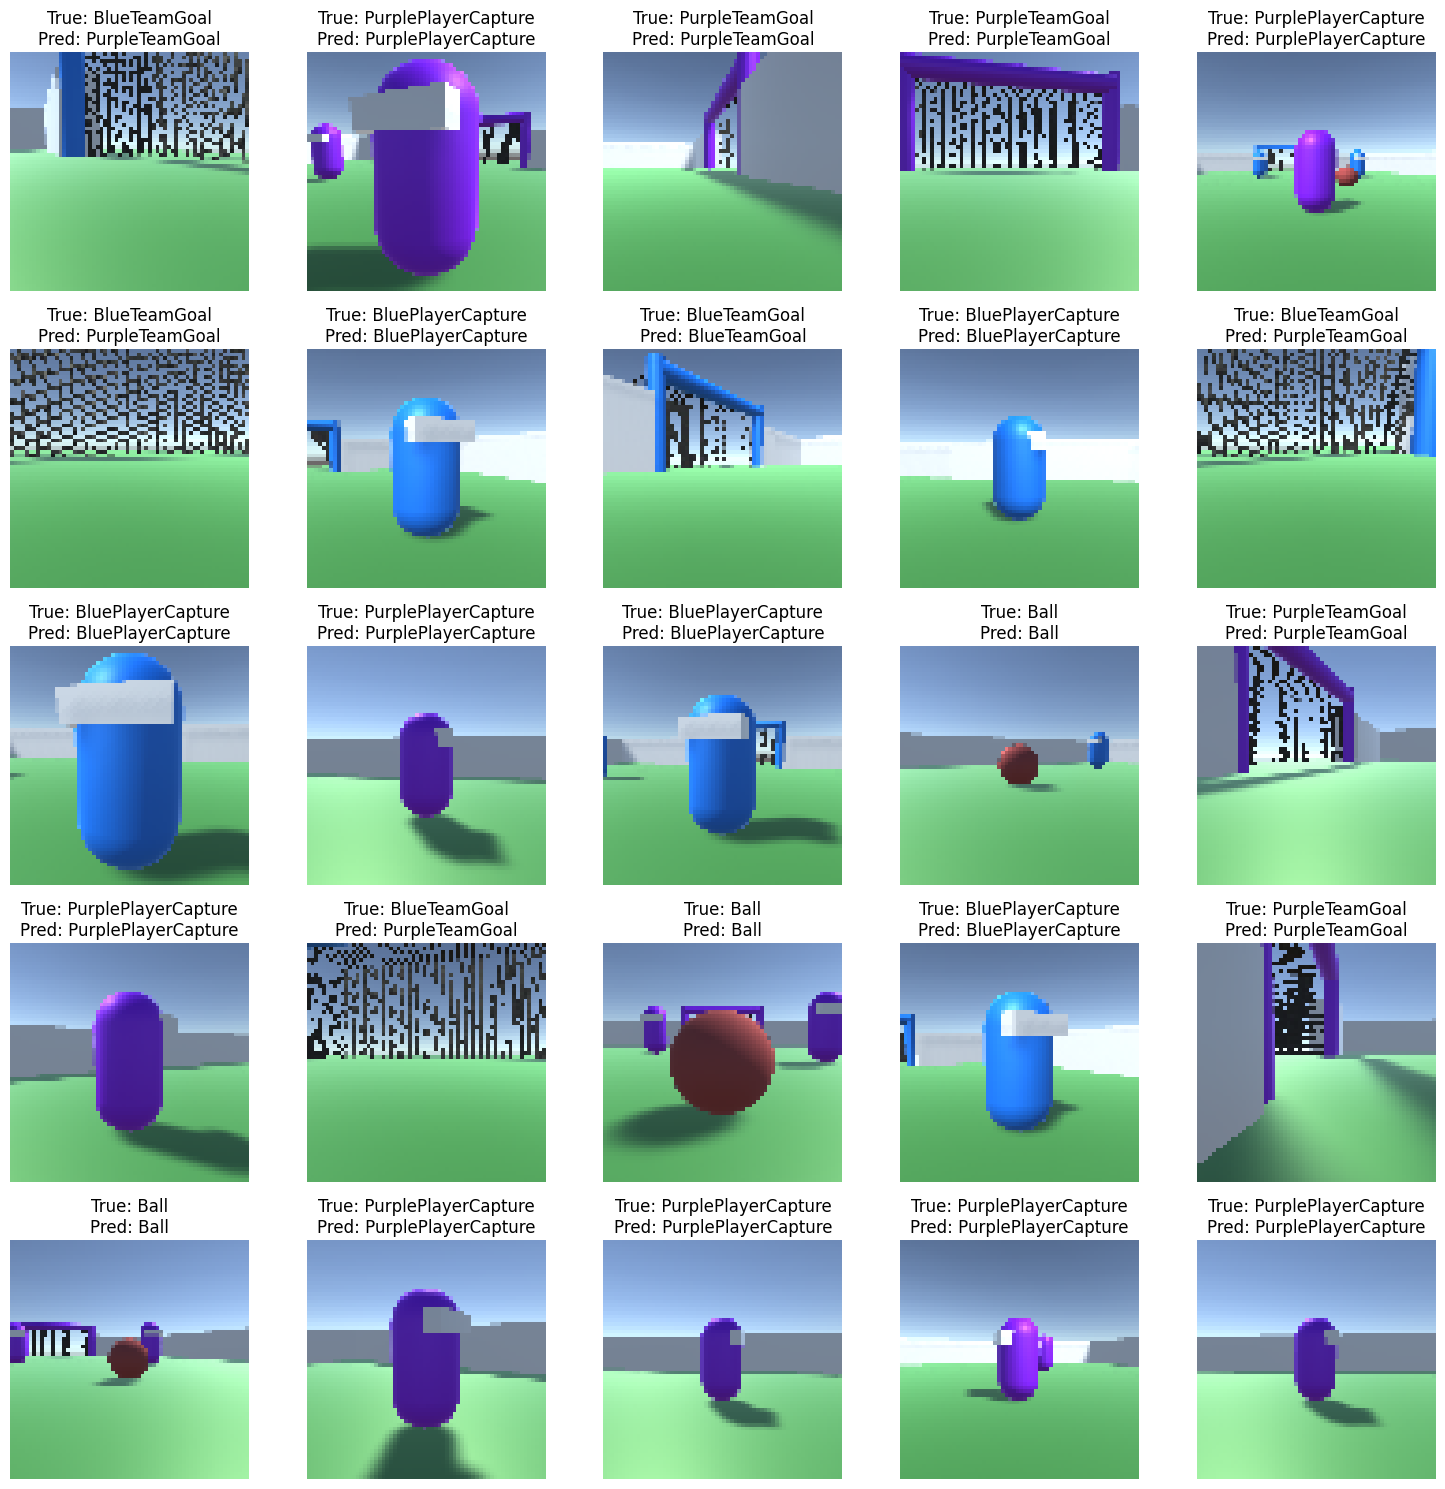

In [17]:
test_labels = test_generator.classes

# Predict the probabilities on the test data
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_classes)

print(cm)

# Plot the confusion matrix
plot_confusion_matrix(cm, test_generator)

# Plotting a batch of images with their true and predicted labels
plot_images_with_predictions(test_generator, model)

In [19]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    # Add more layers as needed
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy', metrics=['accuracy'])
trained_model_reduce_epochs = model.fit(train_generator,validation_data = test_generator, epochs=60)

C:\Users\Søren Merved\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.1983 - loss: 1.6293 - val_accuracy: 0.5602 - val_loss: 1.4905
Epoch 2/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.3905 - loss: 1.4611 - val_accuracy: 0.5093 - val_loss: 1.3046
Epoch 3/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.4301 - loss: 1.3272 - val_accuracy: 0.6806 - val_loss: 1.0667
Epoch 4/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.5432 - loss: 1.1176 - val_accuracy: 0.8588 - val_loss: 0.8177
Epoch 5/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.6783 - loss: 0.9133 - val_accuracy: 0.8495 - val_loss: 0.6462
Epoch 6/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.7173 - loss: 0.7968 - val_accuracy: 0.8194 - val_loss: 0.5936
Epoch 7/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.7167 - loss: 0.7260 - val_accuracy: 0.8588 - val_loss: 0.5100
Epoch 8/60
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.7763 - loss: 0.6133 - val_accuracy: 0.

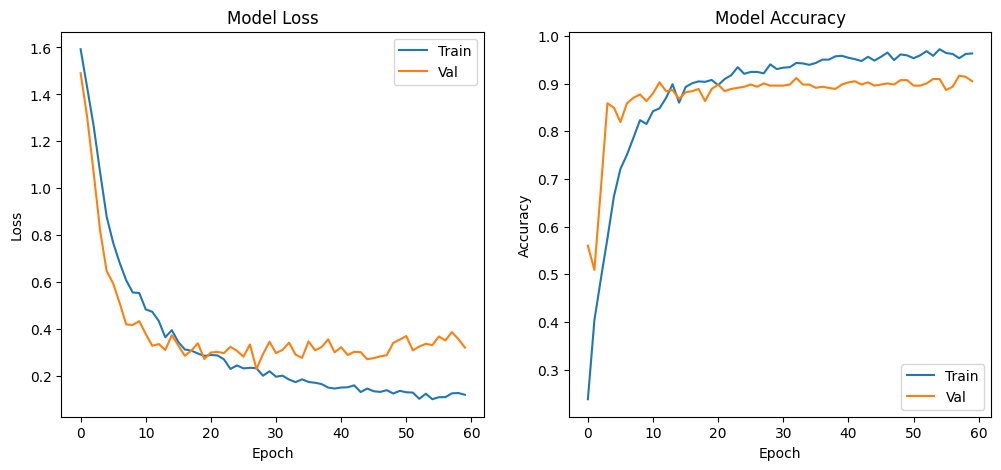

In [20]:
plot_model_metrics(trained_model_reduce_epochs)

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/stepWARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000017EA3C60940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
[[87  0  7  0  0]
 [ 0 95  0  0  0]
 [ 0  0 37  0 33]
 [ 0  0  0 92  0]
 [ 1  0  0  0 80]]


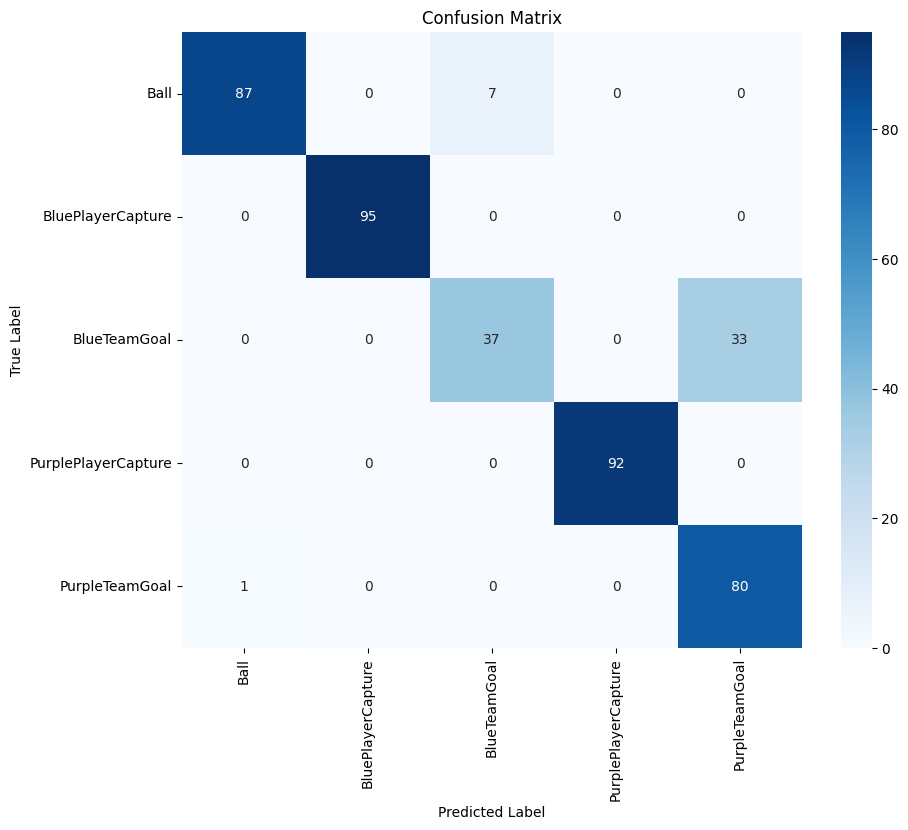

In [21]:
test_labels = test_generator.classes

# Predict the probabilities on the test data
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_classes)

print(cm)

plot_confusion_matrix(cm, test_generator)